# Model comparison with pymc: application to ARX models

In most data analysis workflow, you choice of the most appropriate model is not obvious. There are always several ways to formulate the relationship between measured variables, and to define the unobserved parameters.

When comparing models, in order to select one for a particular problem, the first question is what metric is used to qualify which model is "best". Bayesian software packages use a metric called ELPD: the theoretical expected log pointwise predictive density for a new dataset, i.e. a measure of how well we expect a fitted predictive model to perform outside of its training dataset.

The ELPD can be estimated by leave-one-out (LOO) cross-validation or the widely applicable information criterion (WAIC). Stan has [the loo package](https://mc-stan.org/loo/index.html) and PyMC [can compute LOO or WAIC using the ArviZ package](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html). They recommend using LOO over WAIC because it comes with additional diagnostics. For time series models however, such as autoregressive models, [leave-future-out](https://mc-stan.org/loo/articles/loo2-lfo.html) cross validation makes more sense than LOO.

This notebook demonstrate these tools using some very simple autoregressive models. For clarity, we are still barely above linear regression models in terms of complexity.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

The data are bi-hourly measurements of heating power, indoor and outdoor temperature in an apartment during 3 days.

In [2]:
df = pd.read_csv('data/armaxdata.csv')
df.head()

,datetime,Ti,Te,P
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


Text(0.5, 0, 'Ti-Te')

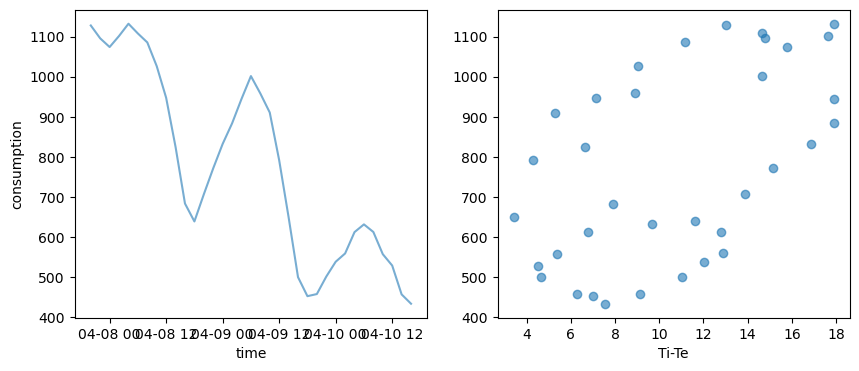

In [3]:
# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#axes[0].plot(df['datetime'], df['Ti'], alpha=0.6)
#axes[0].plot(df['datetime'], df['Te'], alpha=0.6)
axes[0].plot(pd.to_datetime(df['datetime']), df['P'], alpha=0.6)
axes[1].scatter(df['Ti']-df['Te'], df['P'], alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("time")
axes[1].set_xlabel("Ti-Te")

There is clearly not a simple linear relationship between heating power and indoor-outdoor temperature difference, because of the building's inertia.

[Autoregressive models](https://buildingenergygeeks.org/armax.html) (AR) are based on the idea that the current value of the series, $y_t$, can be explained as a function of $p$ past values, $y_{t−1}$, $y_{t−2}$, ..., $y_{t−p}$.

$$y_{t−1} = \beta_0 + \beta_1 y_{t−1} + \beta_2 y_{t−2} + ... + \beta_p y_{t−p} + \varepsilon_t$$

They are essentially linear regression models which take *lagged* copies of the dependent variable as explanatory variables. Other variables can be added, leading to the so-called ARX model (AR model with eXplanatory variables).

We wish to predict the heating power $P$ from its own previous values and other measurements. First, we augment the dataset with lagged versions of all its columns.

In [4]:
df_shift = df.shift([0,1,2], fill_value=0)
df_shift.head()

,datetime_0,Ti_0,Te_0,P_0,datetime_1,Ti_1,Te_1,P_1,datetime_2,Ti_2,Te_2,P_2
0,2023-04-07 20:00:00,21.017708,8.008333,1127.547691,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691,0,0.000000,0.000000,0.000000
2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890


Then we should remove the first 2 rows to make sure partial data doesn't impact model training.

In [5]:
df_shift = df_shift.iloc[2:].reset_index()
df_shift.head()

,index,datetime_0,Ti_0,Te_0,P_0,datetime_1,Ti_1,Te_1,P_1,datetime_2,Ti_2,Te_2,P_2
0,2,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059,2023-04-07 20:00:00,21.017708,8.008333,1127.547691
1,3,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890,2023-04-07 22:00:00,21.022083,6.254167,1095.384059
2,4,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786,2023-04-08 00:00:00,21.023750,5.258333,1073.813890
3,5,2023-04-08 06:00:00,21.014792,6.356250,1107.555516,2023-04-08 04:00:00,21.009167,3.118750,1131.881637,2023-04-08 02:00:00,21.010625,3.381250,1101.343786
4,6,2023-04-08 08:00:00,21.013750,9.864583,1085.307234,2023-04-08 06:00:00,21.014792,6.356250,1107.555516,2023-04-08 04:00:00,21.009167,3.118750,1131.881637


## Zero order model

This first model is an ordinary linear regression model, with no time lag effect.

$$ P_t = \theta (T_i-T_e)_t$$
$$ y_t \sim N(P_t, \sigma)$$
$$ \theta \sim N(50,10) $$
$$ \sigma \sim \mathrm{HalfNormal}(100) $$

* $P_t$ is the heating power estimated at time $t$
* $y_t$ is the heating power *observed* at time $t$. We assume the difference between $P_t$ and $y_t$ is zero-centered noise with a standard deviation $\sigma$
* $\theta$ is the regression coefficient between $P_t$ and $(T_i-T_e)_t$. We guessed its prior from the figure above.
* $\sigma$ is the standard deviation of the prediction uncertainty. We gave it a half normal prior to make sure this value stays positive.

In [6]:
TiTe = df_shift['Ti_0'] - df_shift['Te_0']
Y = df_shift['P_0']

model0 = pm.Model()

with model0:
    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=50, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = theta * TiTe

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_0 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [7]:
az.summary(trace_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,62.693,3.591,56.167,69.612,0.059,0.042,3668.0,2720.0,1.0
sigma,256.855,27.968,202.592,306.703,0.439,0.311,4042.0,2660.0,1.0


Note that we used the keyword `idata_kwargs={"log_likelihood": True}` when we called the sample() function. This is required to compute the point-wise log-likelihood of each sample, which we will need later for model comparison.

MCMC converges correctly (ess and r_hat values are appropriate) but it doesn't mean this model is any "good". We didn't run all model checking routines shown in the first tutorial, but the point here will be to select a model first.

## First order model

We add the first lag of $P$ and $(T_i-T_e)$ to the explanatory variables:

$$ P_t = \beta_1 P_{t-1} + \theta_0 (T_i-T_e)_t + \theta_1 (T_i-T_e)_{t-1}$$

In [8]:
TiTe_1 = df_shift['Ti_1'] - df_shift['Te_1']
P_1 = df_shift['P_1']

model1 = pm.Model()

with model1:
    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=1)
    theta = pm.Normal("theta", mu=30, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = beta * P_1 + theta[0] * TiTe + theta[1] * TiTe_1

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_1 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [9]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.763,0.017,0.733,0.797,0.000,0.000,1768.0,2111.0,1.0
theta[0],1.499,2.017,-2.179,5.326,0.054,0.038,1405.0,1973.0,1.0
theta[1],13.933,2.387,9.488,18.329,0.068,0.049,1228.0,1375.0,1.0
sigma,26.342,3.678,20.411,33.755,0.080,0.058,2241.0,1914.0,1.0


## Second order model

Same as before, but we also add the second lagged value of $P$ and $(T_i-T_e)$:

$$ P_t = \sum_{i=1}^2 \beta_i P_{t-i} + \sum_{j=0}^2 \theta_j (T_i-T_e)_{t-j} $$

In [10]:
TiTe_2 = df_shift['Ti_2'] - df_shift['Te_2']
P_2 = df_shift['P_2']

model2 = pm.Model()

with model2:
    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    theta = pm.Normal("theta", mu=30, sigma=10, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Expected value of outcome
    mu = beta[0] * P_1 + beta[1] * P_2 + theta[0] * TiTe + theta[1] * TiTe_1 + theta[2] * TiTe_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace_2 = pm.sample(2000, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, theta, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 51 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Model comparison

We just trained three models on the same dataset. We will now compare them on the basis of their *expected* prediction performance: the ELPD.

ArviZ has a built-in function to compare several models based on their traces. The default criterion for model comparison is the ELPD calculated by leave-one-out (LOO) cross validation.

In [11]:
df_comp_loo = az.compare({"model0": trace_0, "model1": trace_1, "model2": trace_2}, ic="loo")
df_comp_loo

/home/simon/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/simon/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-156.096240,3.700787,0.000000,1.000000e+00,3.534953,0.000000,False,log
model2,1,-156.950966,4.694519,0.854726,5.023298e-11,3.300017,1.288267,False,log
model0,2,-233.249024,1.304365,77.152784,0.000000e+00,4.092652,4.738686,False,log


Copied from [PyMC's documentation](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html):

* rank, the ranking of the models starting from 0 (best model) to the number of models.
* elpd_loo, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.
* p_loo, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).
* d_loo, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model.
* weight, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.
* se, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.
* dse, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.
* warning, If True the computation of LOO/WAIC may not be reliable.
* loo_scale, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance – this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) – and negative-log – this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better)

We could also have specified `ic="waic"`, which would have compared models based on the WAIC criterion.

/home/simon/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

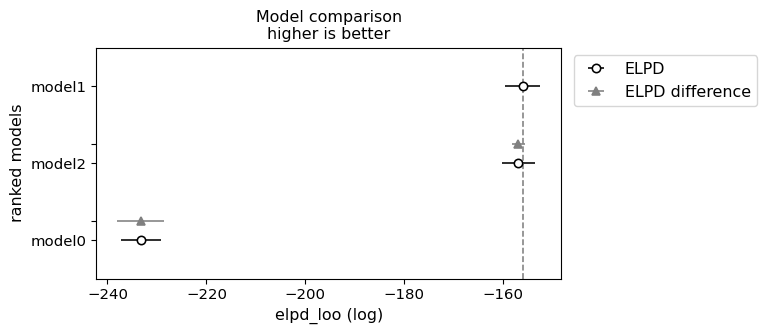

In [12]:
az.plot_compare(df_comp_loo, insample_dev=False)

According to these results, the best choice for prediction is the first order model. The second-order model probably has too many parameters for this small dataset, and the zero-order model predicts poorly.

ArviZ can also display the LOO and WAIC metrics of a single model as follows.

In [13]:
model1_loo = az.loo(trace_1)
model1_loo

Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -156.10     3.53
p_loo        3.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [14]:
model1_waic = az.waic(trace_1)
model1_waic

/home/simon/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -156.01     3.51
p_waic        3.62        -

There has been a warning during the calculation. Please check the results.

## Enhancing the model: ARMAX

We can improve this model by adding a moving average term, which results in [an ARMAX model](https://buildingenergygeeks.org/armax.html). This kind of model is very difficult to write with PyMC, but quite easy to write with Stan. I wrote and example [here](https://srouchier.github.io/bayesmv/)